In [9]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
class Unit: #each unit is an axone
    def __init__(self, value, grad):
        self.value = value # the value passed to the next synapse
        self.grad = grad
        
    def info(self):
        return (self.value, self.grad)
    
class multiplyGate: # a multiplicative synapse
    
    def forward(self, u0, u1):
        self.u0 = u0
        self.u1 = u1
        self.utop = Unit(u0.value * u1.value, 0.0)
        return self.utop
        
    def backward(self):
        self.u0.grad += self.u1.value * self.utop.grad
        self.u1.grad += self.u0.value * self.utop.grad

class sigmoidGate: #a sigmoid activation gate
    
    def sig(self, x):
        return 1/(1.0+np.exp(-x))
    
    def forward(self, u0):
        self.u0 = u0
        self.utop = Unit(self.sig(self.u0.value), 0.0)
        return self.utop
    
    def backward(self):
        s = self.sig(self.u0.value)
        self.u0.grad += (s * (1.0-s)) * self.utop.grad
    

class addGate: #an additive activation gate
    
    def forward(self, u0, u1):
        self.u0 = u0
        self.u1 = u1
        self.utop = Unit(self.u0.value+self.u1.value, 0.0)
        return self.utop
    

    def backward(self):
        self.u0.grad += 1.0 * self.utop.grad
        self.u1.grad += 1.0 * self.utop.grad
        

In [5]:
# The axones

a = Unit(1, 0)
b = Unit(2, 0)
c = Unit(-3, 0)
x = Unit(-1, 0)
y = Unit(3, 0)

# The Gates

mul0 = multiplyGate()
mul1 = multiplyGate()
add0 = addGate()
add1 = addGate()
sg0 = sigmoidGate()

# Forward Pass

def forwardNeuron():
    
    add1.forward(add0.forward(mul0.forward(a, x), mul1.forward(b, y)), c)    
    return sg0.forward(add1.utop)
    
    #s= sg0.forward(add1.forward(c, add0.forward( mul0.forward(a, x).value, mul1.forward(b, y).value).value).value)

s = forwardNeuron()

def backwardNeuron():
    
    s.grad = 1.0
    sg0.backward()
    add1.backward()
    add0.backward()
    mul1.backward()
    mul0.backward()

    
backwardNeuron()

print(s.value)

def evolve():
    var = 0.01
    a.value += a.grad * var
    b.value += b.grad * var
    c.value += c.grad * var
    x.value += x.grad * var
    y.value += y.grad * var
    
evolve()

s = forwardNeuron()
backwardNeuron()
print(s.value)

0.880797077978
0.882550181622


# SVM

In [6]:
class Circuit:
    
    def __init__(self):
        self.mulg0 = multiplyGate()
        self.mulg1 = multiplyGate()
        self.add0 = addGate()
        self.add1 = addGate()
    
    def forward(self, x, y, a, b, c):
        self.ax = self.mulg0.forward(a, x)
        self.by = self.mulg1.forward(b ,y)
        self.axpby = self.add0.forward(self.ax, self.by)
        self.axpbypc = self.add1.forward(self.axpby, c)
        return self.axpbypc
    
    def backward(self, gradient_top):
        self.axpbypc.grad = gradient_top
        self.add1.backward()
        self.add0.backward()
        self.mulg1.backward()
        self.mulg0.backward()
    
    def evolve(self, var):
        self.mulg0.u0.value += self.mulg0.u0.grad * var
        self.mulg1.u0.value += self.mulg1.u0.grad * var
        self.add1.u1.value += self.add1.u1.grad * var
        
    
    
    
class SVM:
    
    def __init__(self):
        self.a = Unit(1, 0)
        self.b = Unit(-2, 0)
        self.c = Unit(-1, 0)
        self.circuit = Circuit()
        
    def forward(self, x, y):
        self.unit_out = self.circuit.forward(x, y, self.a, self.b, self.c)
        return self.unit_out
    
    def backward(self, label):
        self.a.grad = 0
        self.b.grad = 0
        self.c.grad = 0
        
        pull = 0
        
        if (label == 1) & (self.unit_out.value < 1): 
            pull = 1
            
        if (label == -1) & (self.unit_out.value > -1): 
            pull = -1
        
        self.circuit.backward(pull)
            
        self.a.grad += -self.a.value
        self.b.grad += -self.b.value
        self.c.grad += -self.c.value
        
    def learnFrom(self, x, y, label):
        self.forward(x, y)
        self.backward(label)
        self.parameterUpdate()
        
    def parameterUpdate(self):
        step_size = 0.01
        self.a.value += step_size * self.a.grad
        self.b.value += step_size * self.b.grad
        self.c.value += step_size * self.c.grad

In [7]:
data = []
labels = []

data.append([1.2, 0.7])
labels.append(1)

data.append([-0.3, -0.5])
labels.append(-1)

data.append([3.0, 0.1])
labels.append(1)

data.append([-0.1, -1.0])
labels.append(-1)

data.append([-1.0, 1.1])
labels.append(-1)

data.append([2.1, -3])
labels.append(1)

svm = SVM()

def evalTrainingAccuracy():
    num_correct = 0
    debug = 0
    for i in range(0, len(data)):
        x = Unit(data[i][0], 0.0)
        y = Unit(data[i][1], 0.0)
        true_label = labels[i]
        if svm.forward(x, y).value > 0:
            predicted_label = 1
        else:
            predicted_label = -1
        if (predicted_label == true_label):
            num_correct+=1
    
    if debug:
        print('x :',x.info(), 'y :',y.info())
        print('out_value:', svm.forward(x, y).value)
        print('true label:', true_label, 'predicted:', predicted_label) 
        
    return num_correct / len(data)


for iter in range(0,400):
    i = np.int(np.random.rand() * len(data))
    x = Unit(data[i][0], 0.0)
    y = Unit(data[i][1], 0.0)
    true_label = labels[i]
    svm.learnFrom(x, y, true_label)

    if iter % 10 == 0:
        print('pour l itération ', i, iter, evalTrainingAccuracy())

pour l itération  4 0 0.6666666666666666
pour l itération  1 10 0.6666666666666666
pour l itération  4 20 0.6666666666666666
pour l itération  0 30 0.6666666666666666
pour l itération  1 40 0.6666666666666666
pour l itération  4 50 0.6666666666666666
pour l itération  5 60 0.6666666666666666
pour l itération  3 70 0.6666666666666666
pour l itération  5 80 0.6666666666666666
pour l itération  3 90 0.8333333333333334
pour l itération  0 100 0.8333333333333334
pour l itération  1 110 0.8333333333333334
pour l itération  5 120 0.8333333333333334
pour l itération  2 130 0.8333333333333334
pour l itération  3 140 1.0
pour l itération  2 150 1.0
pour l itération  4 160 1.0
pour l itération  0 170 1.0
pour l itération  1 180 1.0
pour l itération  3 190 1.0
pour l itération  0 200 1.0
pour l itération  0 210 1.0
pour l itération  2 220 1.0
pour l itération  3 230 1.0
pour l itération  5 240 1.0
pour l itération  3 250 1.0
pour l itération  4 260 1.0
pour l itération  3 270 1.0
pour l itération 

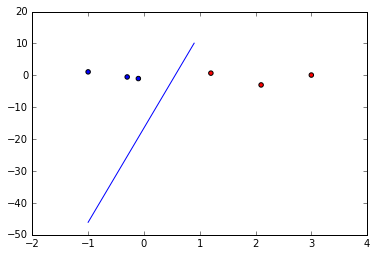

In [43]:
xs = [x[0] for x in data]
ys = [x[1] for x in data]

def mark(l):
    if l > 0: return 'red'
    else: return 'blue'


l = [mark(x) for x in labels]

plt.scatter(xs,ys, c=l)

def f(x):
    return (-svm.a.value*x-svm.c.value)/svm.b.value

r = np.arange(-1, 1, 0.1)
    
plt.plot(r,f(r))

['o', 'x', 'o', 'x', 'x', 'o']

In [32]:
labels

[1, -1, 1, -1, -1, 1]